In [290]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Synthetic Circle

In [291]:
# Create dataframe from csv
df = pd.read_csv('circles.csv') 

In [292]:
# Peek at few rows of the dataframe
df.head()

,x,y,class
0,3.15676,116.12252,6
1,16.14436,16.81660,11
2,100.31212,64.99025,53
3,-1.33773,84.81772,4
4,104.37328,62.42373,53


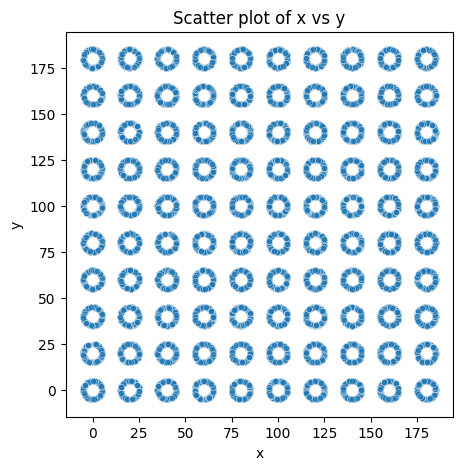

In [293]:
# Scatter plot of the data points   
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='x', y='y', s=20, color='tab:blue', alpha=0.7)
plt.title('Scatter plot of x vs y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Plotted graph to verify that the "dataset comprises ... points arranged into 100 circles"

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   y       10000 non-null  float64
 2   class   10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB


$1000$ non-null data rows. $x,y \in$ float and class $\in$ int

In [295]:
df.describe()

,x,y,class
count,10000.000000,10000.000000,10000.000000
mean,89.981670,90.003827,49.500000
std,57.457467,57.559719,28.867513
min,-5.000000,-4.999860,0.000000
25%,40.237885,40.133840,24.750000
50%,89.999995,90.000080,49.500000
75%,139.898800,139.977695,74.250000
max,184.999920,185.000000,99.000000


In [296]:
print(df.isnull().sum())
df[df.duplicated(keep=False)]

x        0
y        0
class    0
dtype: int64


,x,y,class


No null entries and no duplicate rows with duplicates

In [297]:
# Data Normalization (Z-score Normalization) 
for col in ['x','y']:
    mean = df[col].mean()
    std = df[col].std()
    df[col] = (df[col] - mean) / std

Performed z-score normalization. Rationale for choosing z-score instead of min-max or other normalization techniques. Tried clustering with both and compared performance. 

In [298]:
df.head()

,x,y,class
0,-1.511116,0.453767,6
1,-1.285078,-1.271501,11
2,0.179793,-0.434567,53
3,-1.589339,-0.090100,4
4,0.250474,-0.479156,53


In [299]:
#Kmeans Clustering algorithm 
# def euclidean_distance(point, data):
#     return np.sqrt(np.sum((point - data) ** 2))

# class KMeans: 
#     #initialize k and max iterations (to prevent infinite loops)
#     def __init__(self, k, max_iterations=100):
#         self.k = k
#         self.max_iterations = max_iterations
    
#     #Main Clustering function
#     def fit(self,data):
        
#         #initalize k random centroids 
#         min_c, max_c = np.min(data, axis=0), np.max(data, axis=0)
#         self.centroids = [np.random.uniform(min_c, max_c) for _ in range(self.k)]
            
#         # Iterate to refine centroids till convergence or max iterations
#         curr_iter = 0
#         previous_centroids = None
        
#         pbar = tqdm(total=self.max_iterations, desc="Clustering Progress")
#         while previous_centroids is None or np.not_equal(previous_centroids, self.centroids).any() and curr_iter < self.max_iterations:
            
#             #sort points into clusters by computing distances to centroids and choosing smallest distance
#             sorted_pts = [[] for _ in range(self.k)]
#             for point in data:
#                 dists  = euclidean_distance(point, self.centroids)
#                 centroid_idx = np.argmin(dists)
#                 sorted_pts[centroid_idx].append(point)
            
#             #next step 
#             previous_centroids = self.centroids
#             self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_pts]
#             for i, centroid in enumerate(self.centroids):
#                 if np.isnan(centroid).any():  
#                     self.centroids[i] = previous_centroids[i]
#             curr_iter += 1
#             pbar.update(1)
#         pbar.close()

#     def silhouette_score(self, data):
#         # Assign points to clusters
#         labels = []
#         for point in data:
#             dists = euclidean_distance(point, self.centroids)
#             centroid_idx = np.argmin(dists)
#             labels.append(centroid_idx)
        
#         labels = np.array(labels)
#         silhouette_scores = []
        
#         for i, point in tqdm(enumerate(data), total=len(data), desc="Silhouette Score Progress"):
#             # Points in same cluster
#             same_cluster_mask = labels == labels[i]
#             same_cluster_points = data[same_cluster_mask]
            
#             # Calculate a: mean distance to points in same cluster
#             if len(same_cluster_points) > 1:
#                 a = np.mean([euclidean_distance(point, p) for p in same_cluster_points if not np.array_equal(p, point)])
#             else:
#                 a = 0
            
#             # Calculate b: minimum mean distance to points in other clusters
#             b = np.inf
#             for cluster_idx in range(self.k):
#                 if cluster_idx != labels[i]:
#                     other_cluster_mask = labels == cluster_idx
#                     other_cluster_points = data[other_cluster_mask]
#                     if len(other_cluster_points) > 0:
#                         mean_dist = np.mean([euclidean_distance(point, p) for p in other_cluster_points])
#                         b = min(b, mean_dist)
            
#             # Calculate silhouette score for this point
#             if max(a, b) > 0:
#                 silhouette_scores.append((b - a) / max(a, b))
#             else:
#                 silhouette_scores.append(0)
        
#         return np.mean(silhouette_scores)

In [300]:
# X = df[['x','y']].values 
# kmeans = KMeans(k=100, max_iterations=100)
# kmeans.fit(X)
# score = kmeans.silhouette_score(df[['x','y']].values)
# print(f'Silhouette Score: {score}')

In [301]:
# from sklearn.cluster import KMeans as SKKMeans
# from sklearn.metrics import silhouette_score
# # X = your feature array, shape (n_points, 2)
# k = 100  # same as your custom KMeans

# sk_kmeans = SKKMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
# sk_kmeans.fit(X)

# # Get cluster labels
# labels_sk = sk_kmeans.labels_
# S_sk = silhouette_score(X, labels_sk)
# print(f"Sklearn KMeans Silhouette Score: {S_sk:.4f}")

# Bank Marketing

## About the Dataset

The dataset is captured by a Portuguese banking institution for the purpose of improving their direct marketing campaign. The classification goal is to predict if the client will subscribe to a term deposit.

The about section of the dataset provides other key insights that guides our data exploration and pre-processing. The datasets we have considered (as per the question) is the one with 17 features split into a complete csv dataset with all the data points (total 45211) and another csv dataset with a 10% randomly selected sample.

The data-types are either Categorical or Integer. The categorical data-types will need to be encoded with one-hot encoding. The about section also mentions that some features have missing values which means they will either need to be dropped or we need to impute the value.

In [302]:
# Load the bank marketing dataset properly
import re

def parse_bank_csv_line(line):
    # Remove outer quotes and split by semicolon, then clean inner quotes
    line = line.strip().strip('"')  
    parts = line.split(';')
    cleaned_parts = []
    for part in parts:
        # Remove double quotes around values
        part = part.strip('""')
        cleaned_parts.append(part)
    return cleaned_parts

# Read and parse the file
data = []
with open('bank_marketing/bank-full.csv', 'r', encoding='utf-8') as f:
    for line in f:
        parsed_line = parse_bank_csv_line(line.strip())
        data.append(parsed_line)

# Create DataFrame
columns = data[0]  # First row is header
df_bank = pd.DataFrame(data[1:], columns=columns)

In [303]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [304]:
df.isnull().sum().sum()

np.int64(0)

In [305]:
# how many occurances of "unknown" in entire df_bank
total_unknowns = sum((df_bank[col] == "unknown").sum() for col in df_bank.columns)
total_unknowns

np.int64(52124)

In [306]:
# converting integer columns to int
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Convert columns to integers
for col in integer_columns:
    if col in df_bank.columns:
        df_bank[col] = pd.to_numeric(df_bank[col], errors='coerce').astype('Int64')  # Use Int64 to handle NaN values

df.dtypes

x        float64
y        float64
class      int64
dtype: object

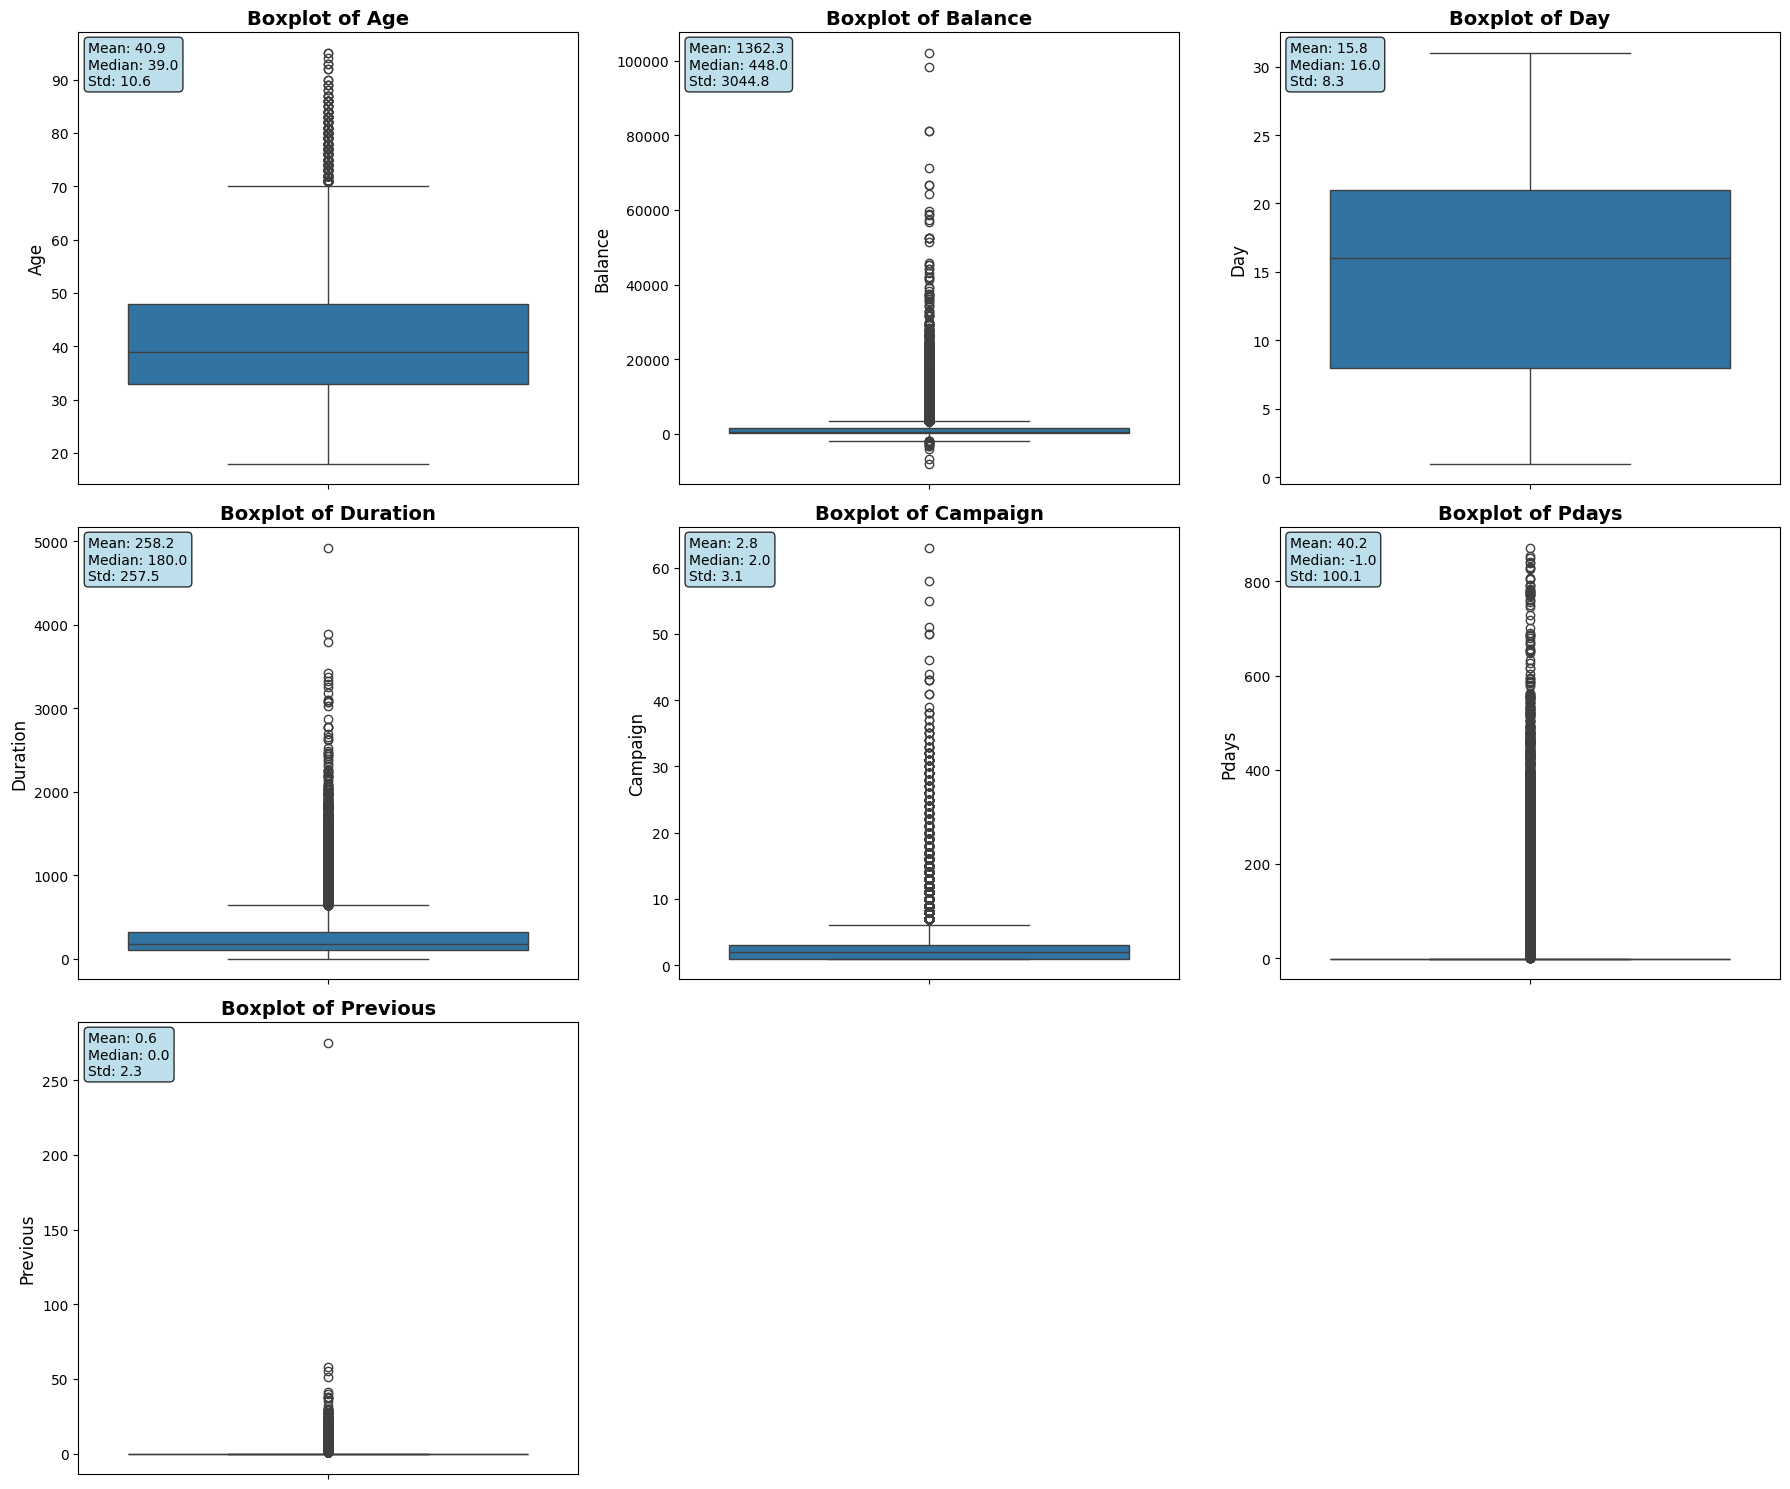

In [307]:
# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(integer_columns):
    if i < len(axes):
        sns.boxplot(data=df_bank, y=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col.title()}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(col.title(), fontsize=12)
        
        # Add statistics text
        mean_val = df_bank[col].mean()
        median_val = df_bank[col].median()
        std_val = df_bank[col].std()
        
        stats_text = f'Mean: {mean_val:.1f}\nMedian: {median_val:.1f}\nStd: {std_val:.1f}'
        axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Hide unused subplots
for j in range(len(integer_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

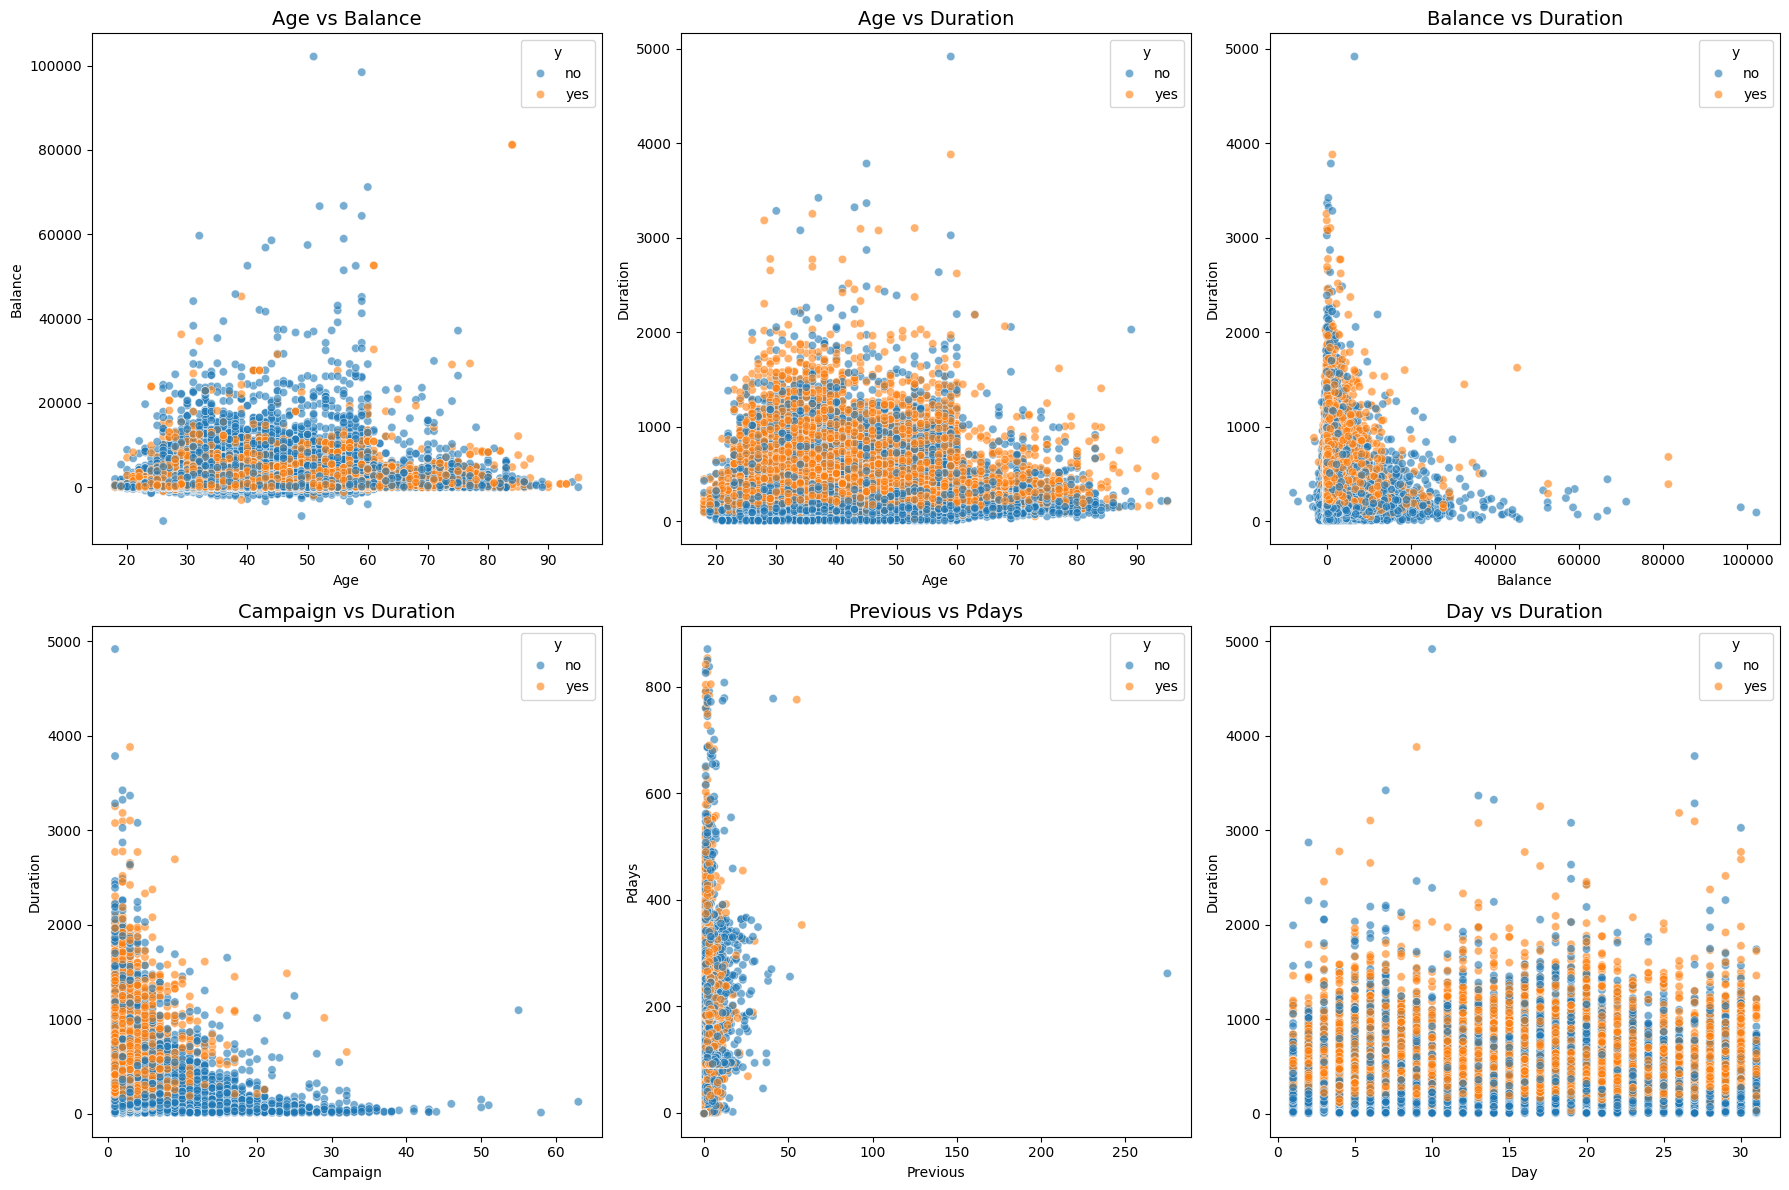

Scatter plots showing relationships between numeric variables.
Points are colored by subscription outcome (y): 'yes' vs 'no'


In [308]:
# Create scatter plots to explore relationships between numeric variables
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create scatter plots for interesting relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define interesting relationships to plot
relationships = [
    ('age', 'balance'),
    ('age', 'duration'),
    ('balance', 'duration'),
    ('campaign', 'duration'),
    ('previous', 'pdays'),
    ('day', 'duration')
]

for i, (x_col, y_col) in enumerate(relationships):
    if i < len(axes):
        # Color by target variable 'y' if you want to see subscription patterns
        sns.scatterplot(data=df_bank, x=x_col, y=y_col, hue='y', ax=axes[i], alpha=0.6)
        axes[i].set_title(f'{x_col.title()} vs {y_col.title()}', fontsize=14)
        axes[i].set_xlabel(x_col.title())
        axes[i].set_ylabel(y_col.title())

plt.tight_layout()
plt.show()

print("Scatter plots showing relationships between numeric variables.")
print("Points are colored by subscription outcome (y): 'yes' vs 'no'")

In [309]:
#Outlier remover
# def whisker(col):
#     Q1,Q3 = np.percentile(col,[25,75])
#     iqr = Q3 - Q1
#     lw = Q1 - (1.5 * iqr)
#     uw = Q3 + (1.5 * iqr)
#     return lw, uw

# for col in integer_columns:
#     lw, uw = whisker(df_bank[col])
#     df_bank = df_bank[(df_bank[col] >= lw) & (df_bank[col] <= uw)]

In [310]:
# Z-score Normalization for integer columns
for col in integer_columns:
    mean = df_bank[col].mean()
    std = df_bank[col].std()
    df_bank[col] = (df_bank[col] - mean) / std

df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1.606947,management,married,tertiary,no,0.256416,yes,no,unknown,-1.298462,may,0.011016,-0.569344,-0.411449,-0.251938,unknown,no
1,0.288526,technician,single,secondary,no,-0.43789,yes,no,unknown,-1.298462,may,-0.416122,-0.569344,-0.411449,-0.251938,unknown,no
2,-0.747376,entrepreneur,married,secondary,no,-0.446758,yes,yes,unknown,-1.298462,may,-0.707353,-0.569344,-0.411449,-0.251938,unknown,no
3,0.571045,blue-collar,married,unknown,no,0.047205,yes,no,unknown,-1.298462,may,-0.645224,-0.569344,-0.411449,-0.251938,unknown,no
4,-0.747376,unknown,single,unknown,no,-0.447086,no,no,unknown,-1.298462,may,-0.233618,-0.569344,-0.411449,-0.251938,unknown,no


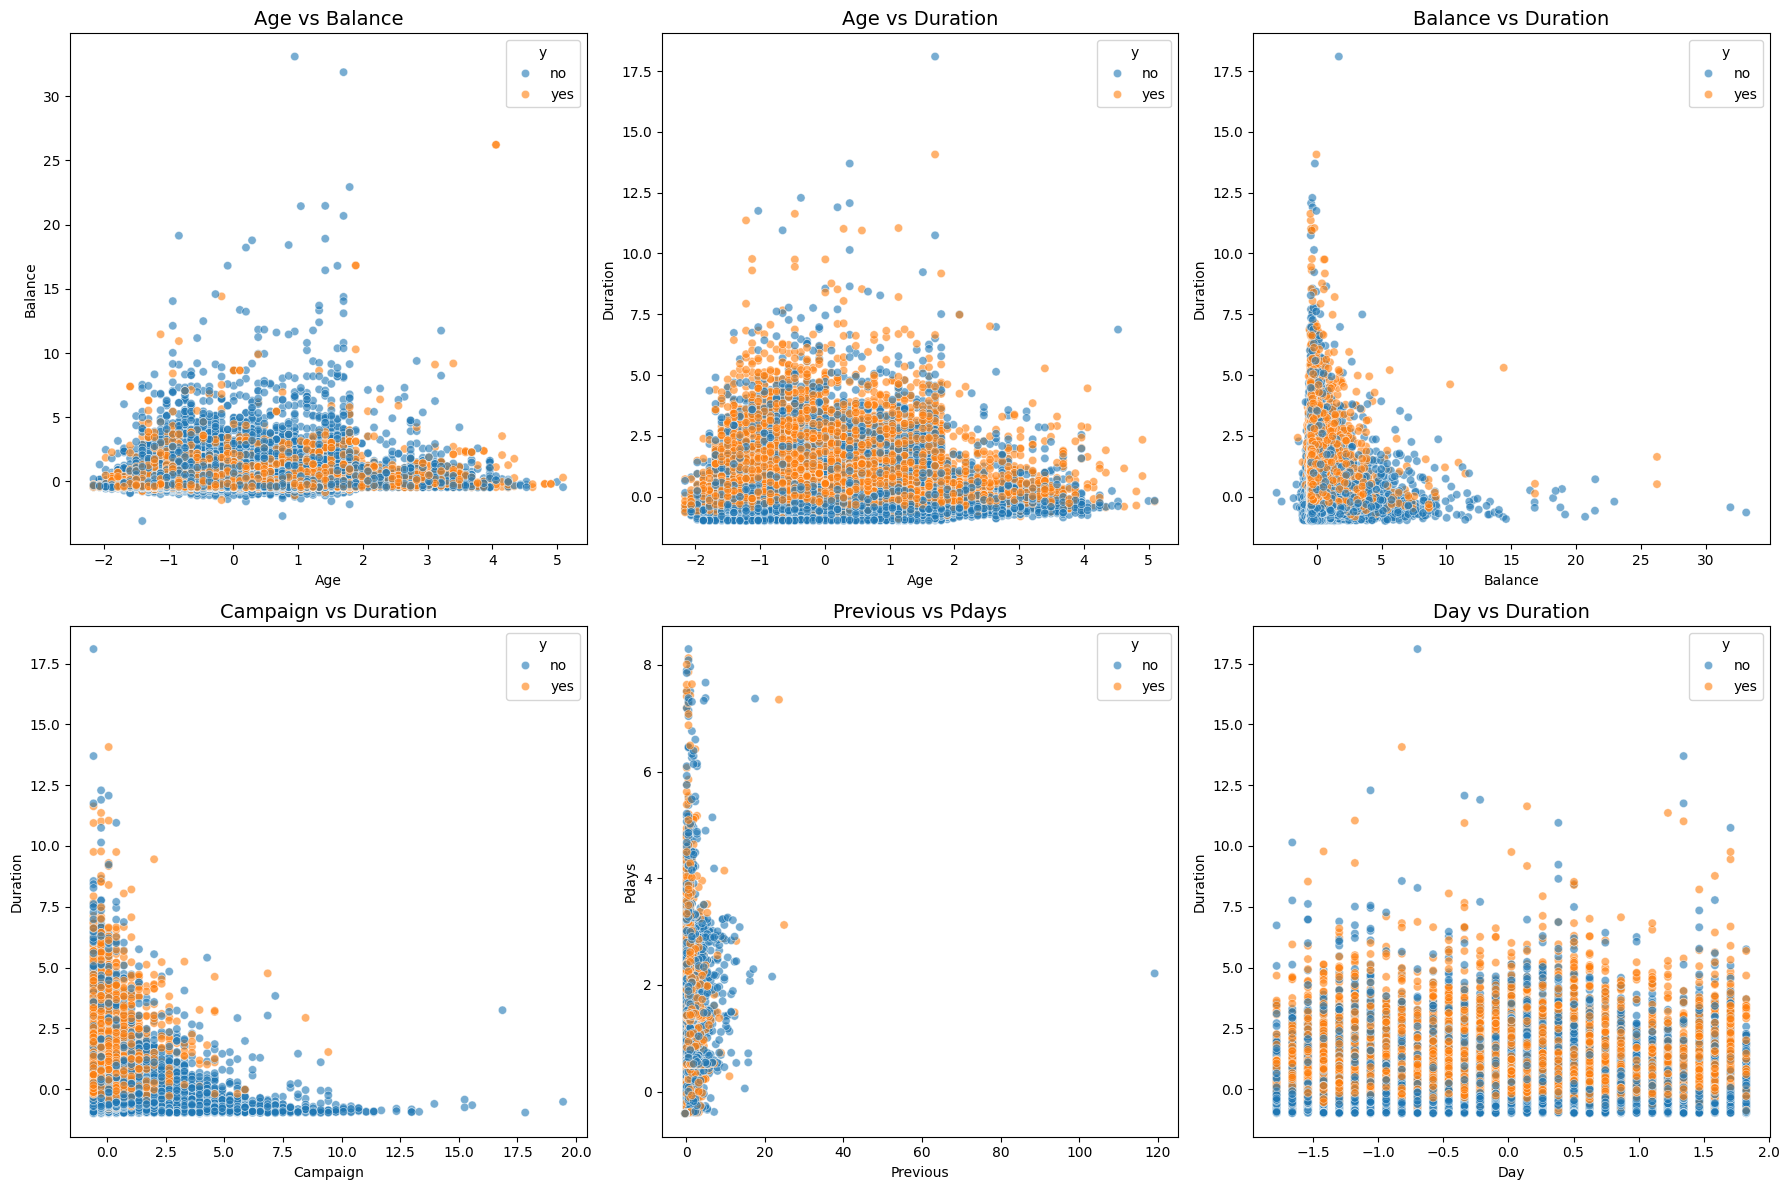

Scatter plots showing relationships between numeric variables.
Points are colored by subscription outcome (y): 'yes' vs 'no'


In [311]:
# Create scatter plots to explore relationships between numeric variables
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create scatter plots for interesting relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define interesting relationships to plot
relationships = [
    ('age', 'balance'),
    ('age', 'duration'),
    ('balance', 'duration'),
    ('campaign', 'duration'),
    ('previous', 'pdays'),
    ('day', 'duration')
]

for i, (x_col, y_col) in enumerate(relationships):
    if i < len(axes):
        # Color by target variable 'y' if you want to see subscription patterns
        sns.scatterplot(data=df_bank, x=x_col, y=y_col, hue='y', ax=axes[i], alpha=0.6)
        axes[i].set_title(f'{x_col.title()} vs {y_col.title()}', fontsize=14)
        axes[i].set_xlabel(x_col.title())
        axes[i].set_ylabel(y_col.title())

plt.tight_layout()
plt.show()

print("Scatter plots showing relationships between numeric variables.")
print("Points are colored by subscription outcome (y): 'yes' vs 'no'")

In [312]:
replacements = {'yes': '1', 'no': '0'}
df_bank['y'] = df_bank['y'].replace(replacements)
df['y'] = df_bank['y'].astype(int)

In [313]:
categorical_columns = df_bank.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')  # Exclude target variable
df_bank = pd.get_dummies(df_bank, columns=categorical_columns, drop_first=True, dtype=int)
df_bank.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.288526,-0.43789,-1.298462,-0.416122,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,-0.411449,-0.251938,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,-0.411449,-0.251938,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,1,0,0,0,0,0,1
